## Visualizing the quality of images produced by the denoising autoencoder

In [1]:
import random

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision

from data_helper import AddGaussianNoise, CorruptedUnlabeledDataset
from denoising_autoencoder import DenoisingAutoencoder

matplotlib.rcParams['figure.figsize'] = [5, 5]
matplotlib.rcParams['figure.dpi'] = 200

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

device = torch.device("cpu")  # cuda:0 if gpu is available


def load_model(path):
    model = DenoisingAutoencoder.load_from_checkpoint(path)
    model.to(device)

    return model


def val_dataloader(batch_size=128):
    transform = torchvision.transforms.Compose(
        [
            torchvision.transforms.Resize((224, 224)),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize((0.54, 0.60, 0.63), (0.34, 0.34, 0.34)),
        ]
    )
    noise = AddGaussianNoise(mean=0.0, std=0.25)

    unlabeled_validset = CorruptedUnlabeledDataset(
        image_folder="../data",
        scene_index=np.arange(100, 106),
        transform=transform,
        noise=noise,
    )

    return torch.utils.data.DataLoader(
        unlabeled_validset, batch_size=batch_size, shuffle=False, num_workers=4
    )

In [2]:
path = "./saved_models/denoising_autoencoder.ckpt"

model = load_model(path)
model.eval()

DenoisingAutoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 256, kernel_size=(3, 3), stride=(2, 2))
    (1): LeakyReLU(negative_slope=0.01)
    (2): Conv2d(256, 128, kernel_size=(3, 3), stride=(2, 2))
    (3): LeakyReLU(negative_slope=0.01)
    (4): Conv2d(128, 64, kernel_size=(3, 3), stride=(2, 2))
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv2d(64, 32, kernel_size=(3, 3), stride=(2, 2))
    (7): LeakyReLU(negative_slope=0.01)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): LeakyReLU(negative_slope=0.01)
    (2): ConvTranspose2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
    (3): LeakyReLU(negative_slope=0.01)
    (4): ConvTranspose2d(128, 256, kernel_size=(3, 3), stride=(2, 2))
    (5): LeakyReLU(negative_slope=0.01)
    (6): ConvTranspose2d(256, 3, kernel_size=(3, 3), stride=(2, 2), output_padding=(1, 1))
    (7): Tanh()
  )
)

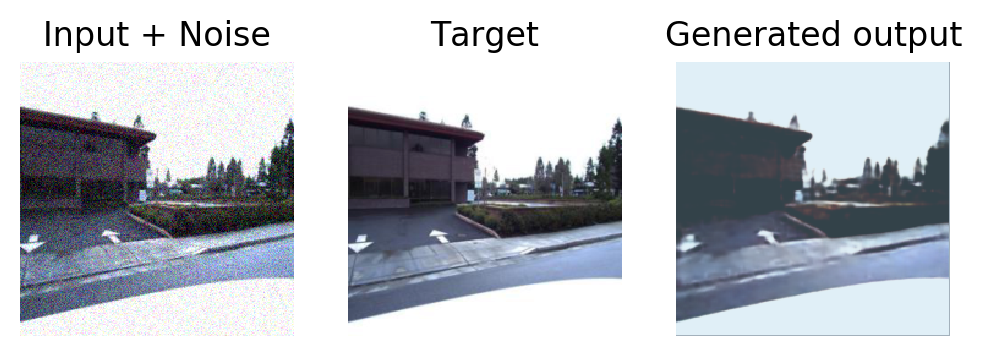

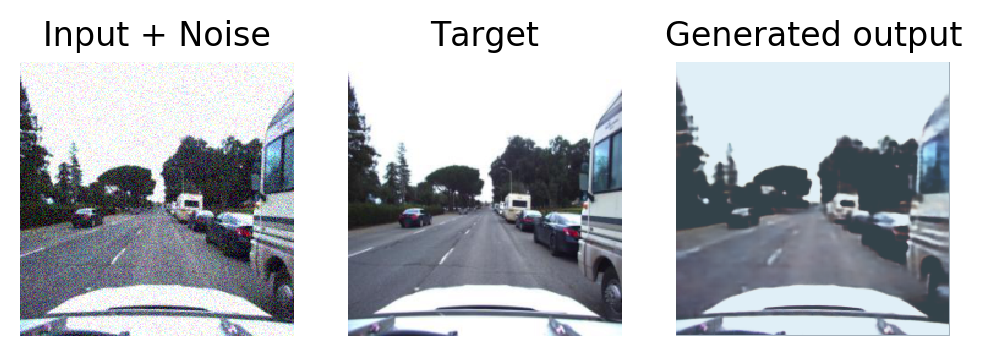

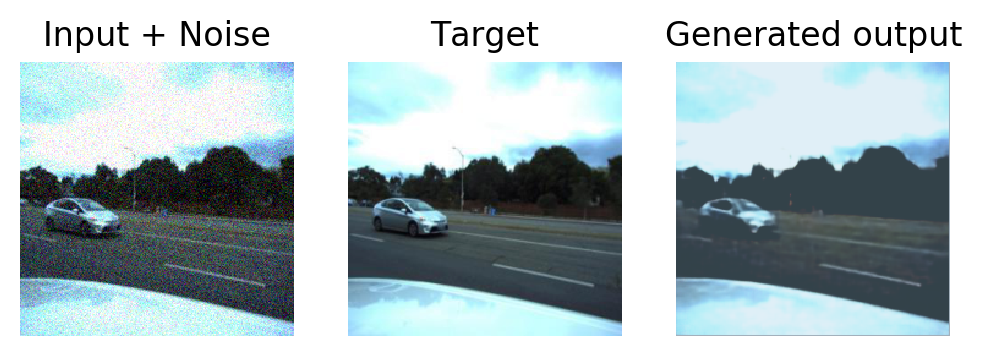

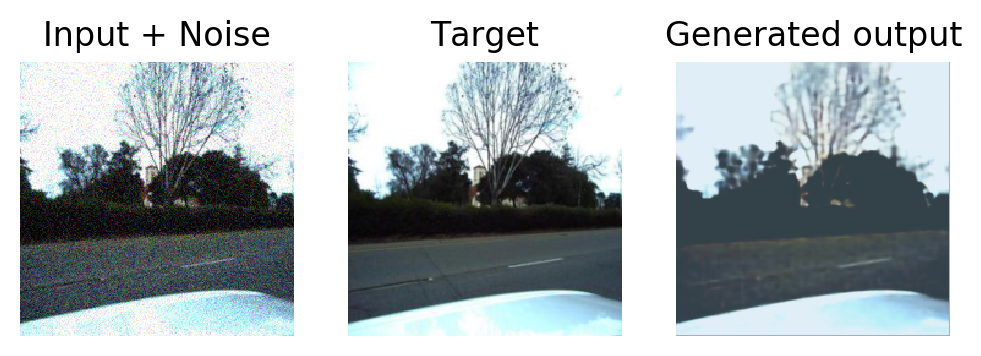

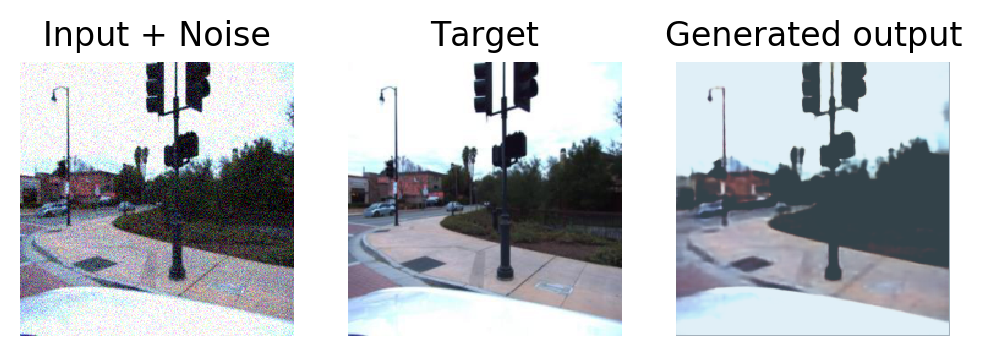

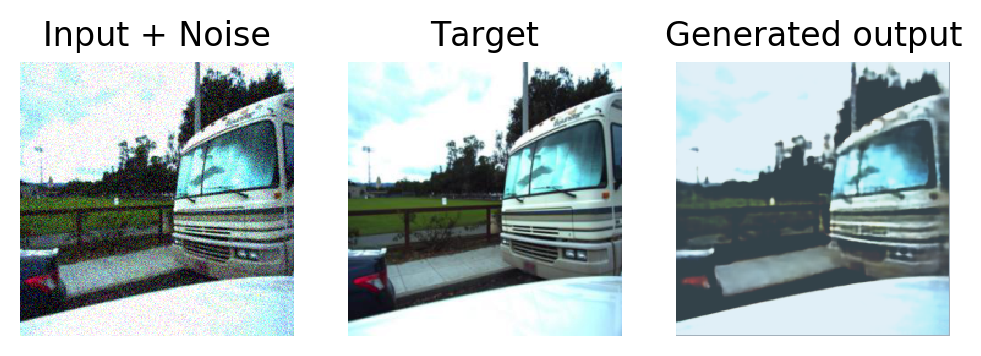

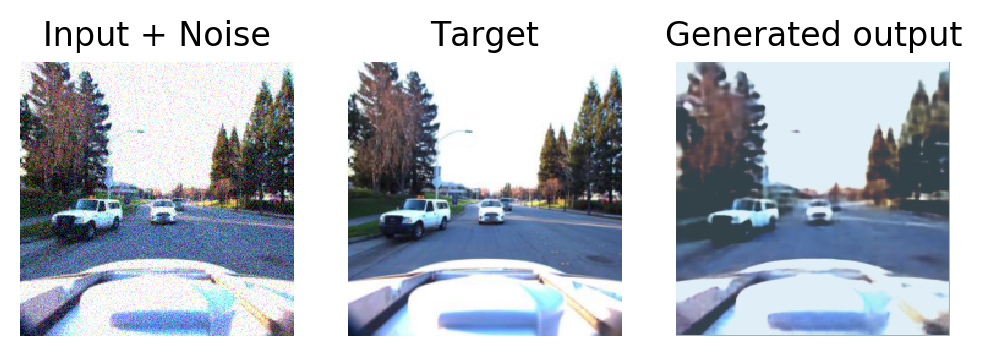

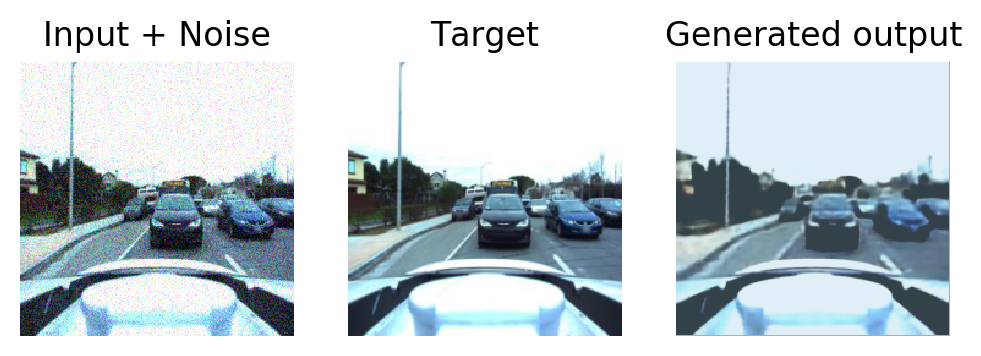

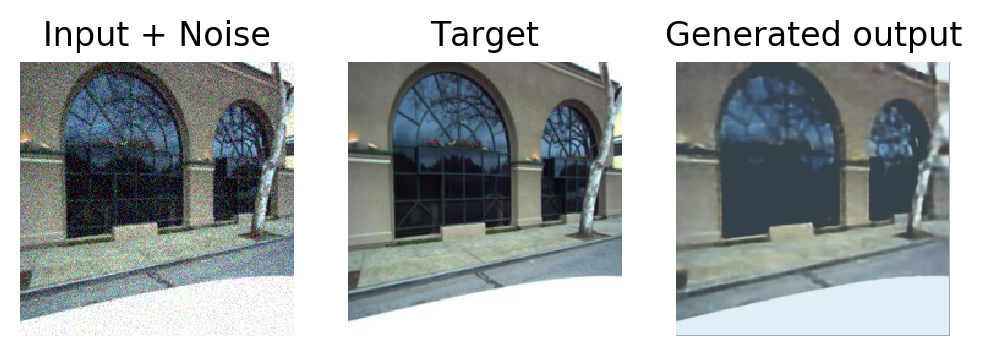

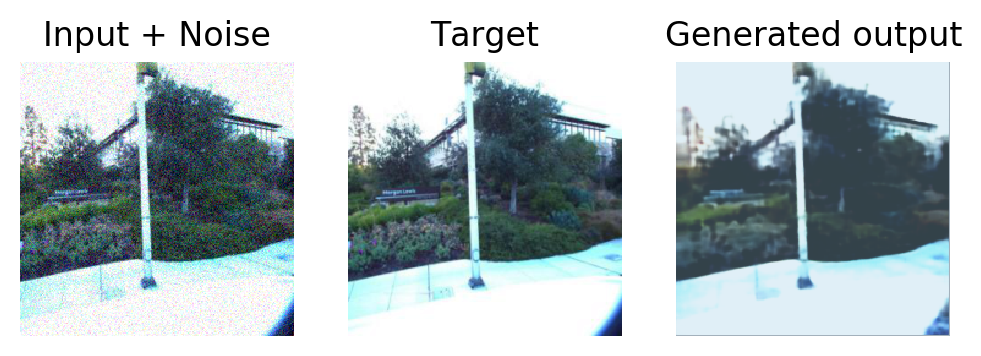

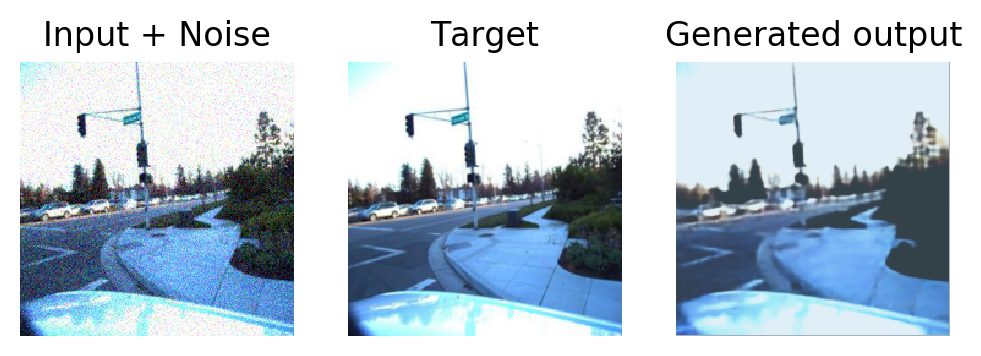

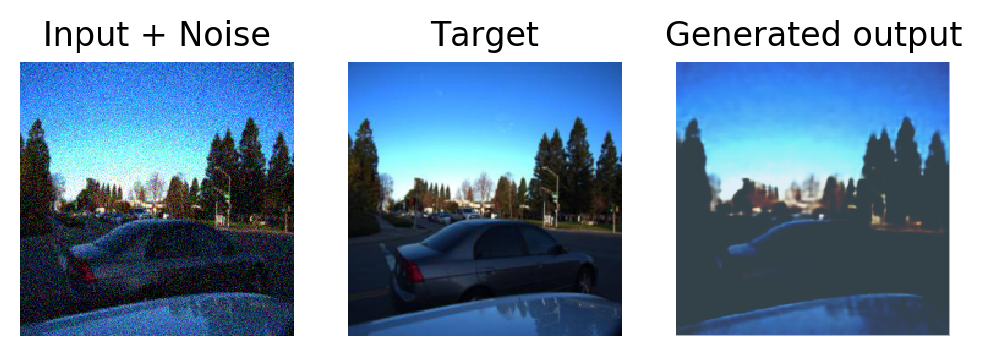

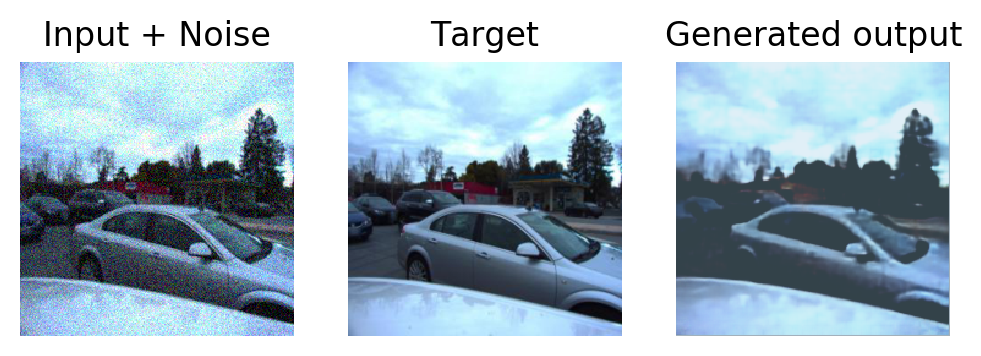

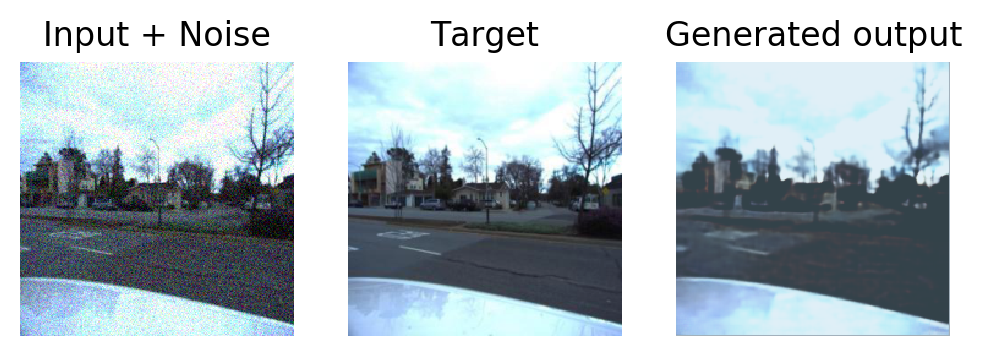

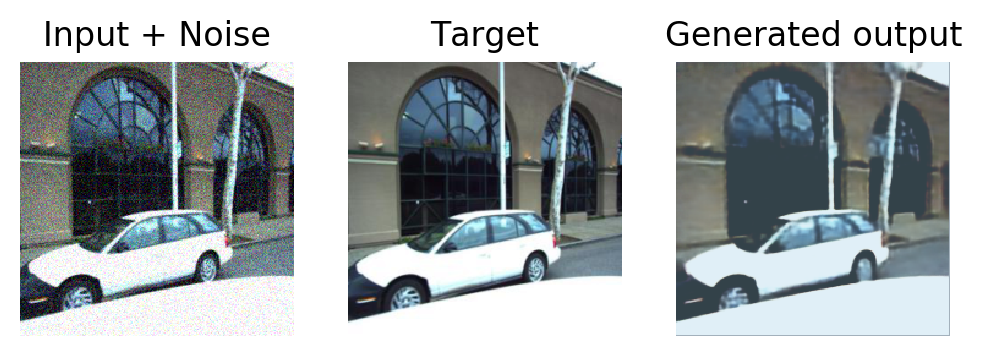

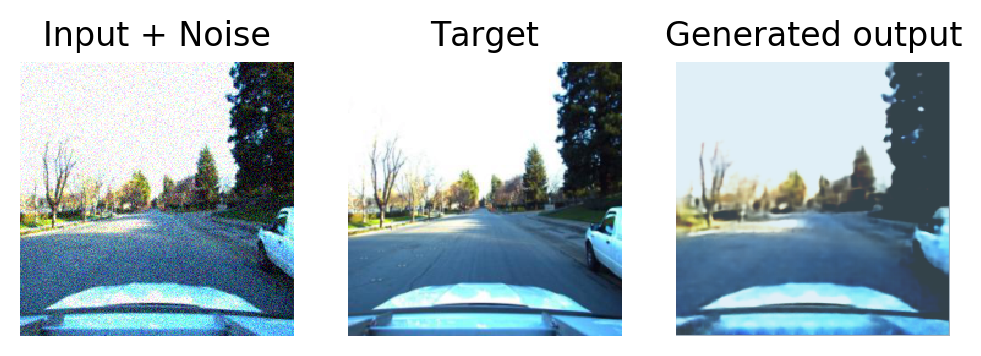

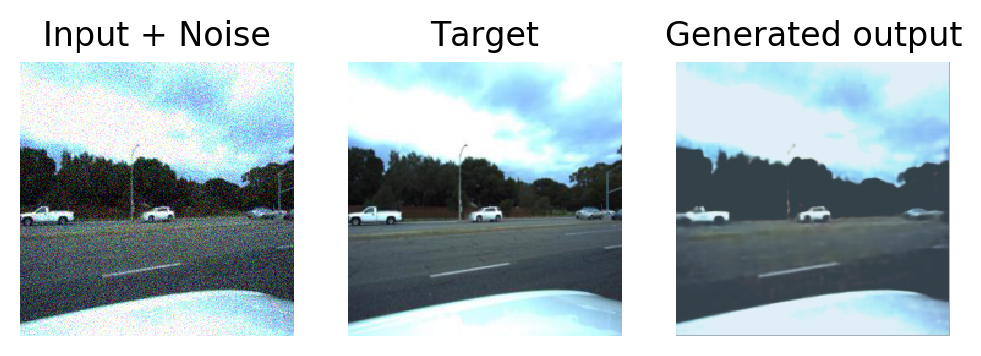

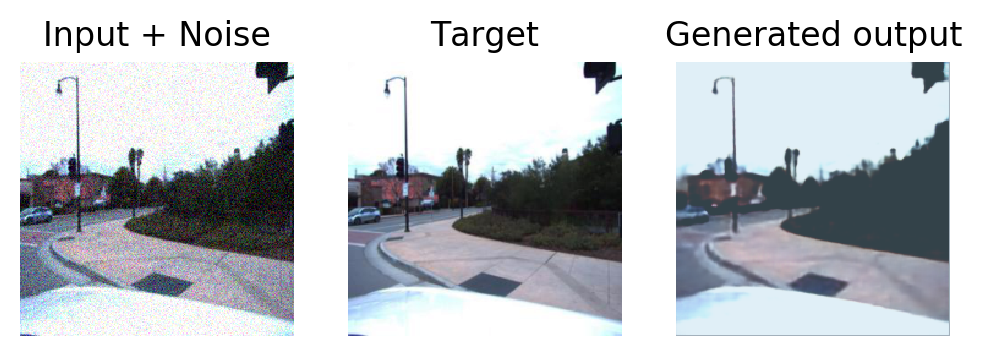

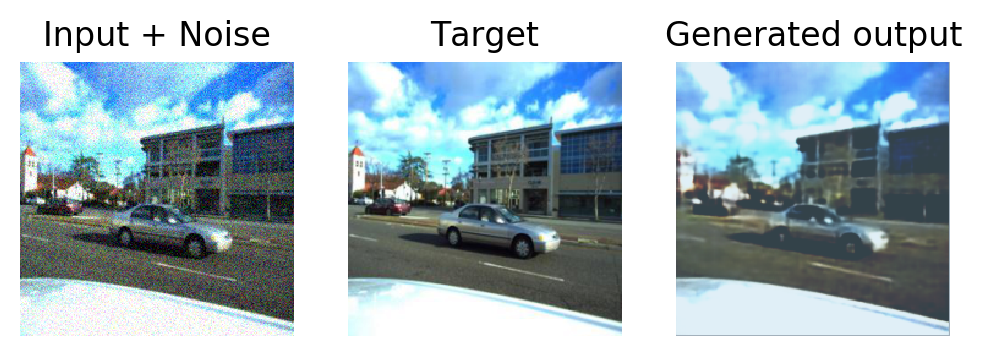

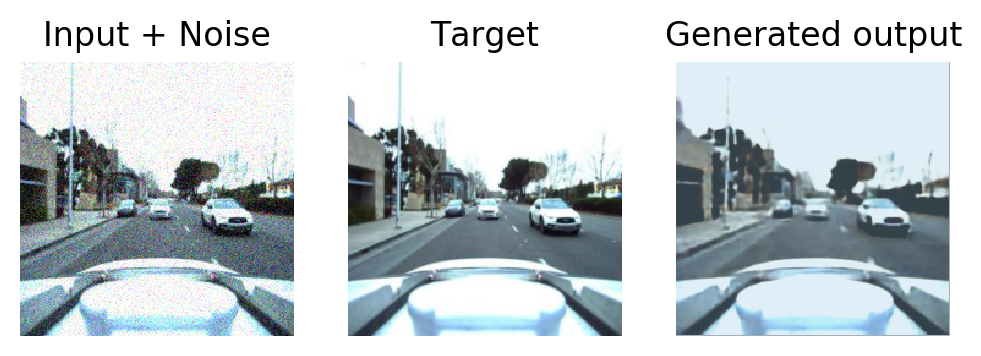

In [3]:
num_samples = 20

# Loading the validation data
# Use a smaller batch size if you get a memory error
valid_loader = val_dataloader(model.hparams.BATCH_SIZE)

# [batch_size, 3, H, W]
sample_input, sample_target = iter(valid_loader).next()
sample_input = sample_input.to(device)
sample_target = sample_target.to(device)

# Getting model predictions ("denoised" reconstruction)
features = model(sample_input)
sample_output = model.decoder(features)

mean_ = torch.tensor([0.54, 0.60, 0.63]).view(1, 3, 1, 1)
std_ = torch.tensor([0.34, 0.34, 0.34]).view(1, 3, 1, 1)

# De-standardising images (for the plots)
sample_input = sample_input.cpu() * std_ + mean_
sample_target = sample_target.cpu() * std_ + mean_
sample_output = sample_output.detach().cpu() * std_ + mean_

sample_idxs = np.random.choice(model.hparams.BATCH_SIZE, num_samples, False)
for sample_idx in sample_idxs:
    plt.figure(figsize=(6, 6))

    plt.subplot(1, 3, 1)
    plt.imshow(sample_input[sample_idx].numpy().transpose(1, 2, 0))
    plt.title("Input + Noise")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(sample_target[sample_idx].numpy().transpose(1, 2, 0))
    plt.title("Target")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(sample_output[sample_idx].numpy().transpose(1, 2, 0))
    plt.title("Generated output")
    plt.axis("off")

    plt.show()